## Encoder Distillation

In [ ]:
import sys
sys.path.append("..")
from pathlib import Path
from tqdm import tqdm

import torch
from transformers import (SamModel, SamProcessor)
from utils.mobile_sam import sam_model_registry
from utils.mobile_sam.predictor import SamPredictor

from utils.datasets import SA1B_Dataset
from utils.utils import *

%load_ext autoreload
%autoreload 2

In [ ]:
# Config
DATA_DIR = Path('../Datasets/')
GPU = 3

DEVICE = torch.device(f"cuda:{GPU}" if torch.cuda.is_available() else "cpu")

In [ ]:
# Dataset
dataset = SA1B_Dataset(root=DATA_DIR.joinpath('SA_1B/images/'), features=None, split='sa_000009')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
len(dataset)

In [ ]:
for j, (i, l, n) in enumerate(dataloader):
    print(i.shape, l.shape, n)
    if j > 10:
        break

In [ ]:
print(len(l.unique()))
plt.imshow(l[0])
plt.show()

In [ ]:
# Teacher
teacher = SamModel.from_pretrained("facebook/sam-vit-huge").to(DEVICE).eval()
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [ ]:
# Student
model_type = "vit_t"
sam_checkpoint = "bin/mobile_sam.pt"

model = sam_model_registry[model_type](checkpoint=None).to(DEVICE).train()
student = SamPredictor(model)

In [ ]:
with torch.no_grad():
    inputs = processor(i, input_points=None, return_tensors="pt").to(DEVICE)
    t_features = teacher.get_image_embeddings(inputs["pixel_values"]).cpu()

In [ ]:
# mse
mse = torch.nn.MSELoss()
mse(t_features, l)

In [ ]:
l

In [ ]:
t_features

In [ ]:
class Distiller():
    def __init__(self, teacher, student, processor, dataloader, optimizer, device):
        self.teacher = teacher
        self.student = student
        self.processor = processor
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.device = device

    def get_distillation_loss(self, img):
        student.set_image(img[0].permute((2,0,1)))
        s_features = student.features

        with torch.no_grad():
            inputs = processor(img, input_points=None, return_tensors="pt").to(DEVICE)
            t_features = teacher.get_image_embeddings(inputs["pixel_values"])

        return torch.nn.functional.mse_loss(s_features, t_features)

    def distill(self):
        t = tqdm(dataloader, desc='Distillation:')
        for img, _, _ in t:
            self.optimizer.zero_grad()
            loss = self.get_distillation_loss(img)
            loss.backward()
            self.optimizer.step()
            t.set_postfix({'Loss': loss.item()})

In [ ]:
optimizer = torch.optim.Adam(student.model.parameters(), lr=1e-3)
distiller = Distiller(teacher, student, processor, dataloader, optimizer, DEVICE)

In [ ]:
distiller.distill()

In [ ]:
torch.save(distiller.student.model.state_dict(), 'bin/distilled_mobile_sam.pt')

In [ ]:
import csv

In [ ]:
teacher_features_ids = csv.reader(open(Path('results/feature_ids.csv'), 'r'))
l = list(teacher_features_ids)
#l = [i[0] for i in l]
len(l)

In [ ]:
l[:5]

In [ ]:
f = torch.load('results/teacher_features.pt')

In [ ]:
len(f)

## Decoder Distillation

- prompt a random point belonging to an instance
- get the corresponding mask and mask size
- use saved SAM features
- freeze MobileSAM backbone
- prompt SAM and MobileSAM and collect output masks (3 masks?)
- compute dice and focal loss (20:1)
- weight loss based on mask size
- OBTAIN LOGITS FROM (MOBILESAM, SAM) !!! (return_logits=True, binarize=False)

In [ ]:
# get_prompt()
# get_instance_label()
# get_mask_size()
# size coefficient = 1 - (mask_size / image_size)
# get_output(SAM, saved_features, prompt)
# get_output(MobileSAM, saved_features, prompt) 
# dice_loss()
# focal_loss()
# loss = (20 * dice_loss() + focal_loss()) * size_coefficient

In [ ]:
from distill import *

In [ ]:
DATA_DIR = Path('../Datasets/')
SPLIT = 'sa_000020'
GPU = 2
DEVICE = torch.device(f"cuda:{GPU}" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 8
SHUFFLE = True
LOAD_FEATURES = True
FEATURES = 'results/teacher_features.pt' if LOAD_FEATURES else None

EPOCHS = 16
LR = 1e-3
OPTIM = 'adamw'
WD = 1e-5
LOSS_WEIGHTS = [0,0,1,0] # 20 focal, 1 dice, 0 bce, 0 size

MODE = 'decoder' # encoder, decoder, save_features
PRETRAINED = True if MODE == 'decoder' else False

dataset = SA1B_Dataset(root=DATA_DIR.joinpath('SA_1B/images/'), split=SPLIT,  features=FEATURES, labels=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=SHUFFLE, num_workers=16, pin_memory=True)

teacher = SamModel.from_pretrained("facebook/sam-vit-huge").to(DEVICE)
teacher.eval()
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

model_type = "vit_t"
sam_checkpoint = "bin/mobile_sam.pt" if PRETRAINED else None

model = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(DEVICE)
model.eval()
for m in model.image_encoder.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        m.eval()
        m.weight.requires_grad_(False)
        m.bias.requires_grad_(False)
student = SamPredictor(model)

if MODE == 'encoder':
    DISTILLER = EncDistiller
    params = student.model.image_encoder.parameters()
else:
    DISTILLER = DecDistiller
    params = student.model.mask_decoder.parameters()

if OPTIM == 'adamw':
    optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
elif OPTIM == 'adam':
    optimizer = torch.optim.Adam(params, lr=LR)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

distiller = DISTILLER(teacher, student, processor, dataloader, optimizer, scheduler, loss_weights=LOSS_WEIGHTS, device=DEVICE)

if MODE == 'save_features':
    distiller.save_teacher_features(Path('results/teacher_features.pt'))
else:
    distiller.distill(epochs=EPOCHS, accumulate=BATCH_SIZE, use_saved_features=LOAD_FEATURES, name=MODE)

## Profiler

In [ ]:
import sys
from pstats import Stats

filename = '../results/profile.prof' 
my_stat = Stats(filename, stream=sys.stdout).sort_stats('time')
my_stat.print_stats(.1)
print()

## Distiller Inspection

In [1]:
import sys
sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
import torch
from transformers import (SamModel, SamProcessor)
from utils.mobile_sam import sam_model_registry
from utils.mobile_sam.automatic_mask_generator import SamAutomaticMaskGenerator
from utils.mobile_sam.predictor import SamPredictor
from utils.datasets import SA1B_Dataset
from utils.utils import *
from utils.distill_utils import *

%load_ext autoreload
%autoreload 2

In [5]:
MS = torch.load('../bin/distilled_mobile_sam_init.pt')
DS = torch.load('../bin/distilled_mobile_sam_decoder_test_size_0.pt')

In [6]:
for k in DS.keys():
    print(f"{k} \t {(MS[k].to('cpu')==DS[k].to('cpu')).all().item()}")

image_encoder.patch_embed.seq.0.c.weight 	 True
image_encoder.patch_embed.seq.0.bn.weight 	 True
image_encoder.patch_embed.seq.0.bn.bias 	 True
image_encoder.patch_embed.seq.0.bn.running_mean 	 True
image_encoder.patch_embed.seq.0.bn.running_var 	 True
image_encoder.patch_embed.seq.0.bn.num_batches_tracked 	 True
image_encoder.patch_embed.seq.2.c.weight 	 True
image_encoder.patch_embed.seq.2.bn.weight 	 True
image_encoder.patch_embed.seq.2.bn.bias 	 True
image_encoder.patch_embed.seq.2.bn.running_mean 	 True
image_encoder.patch_embed.seq.2.bn.running_var 	 True
image_encoder.patch_embed.seq.2.bn.num_batches_tracked 	 True
image_encoder.layers.0.blocks.0.conv1.c.weight 	 True
image_encoder.layers.0.blocks.0.conv1.bn.weight 	 True
image_encoder.layers.0.blocks.0.conv1.bn.bias 	 True
image_encoder.layers.0.blocks.0.conv1.bn.running_mean 	 True
image_encoder.layers.0.blocks.0.conv1.bn.running_var 	 True
image_encoder.layers.0.blocks.0.conv1.bn.num_batches_tracked 	 True
image_encoder.layer

In [ ]:
class GenDistiller(DecDistiller):
    def __init__(self, teacher, student, processor, dataloader, test_dataloader, optimizer, scheduler, loss_weights=[0,0,0,0,1,0], 
                 profile=False, device='cuda', teacher_predictor=None, teacher_gen=None, student_gen=None):
        
        super().__init__(teacher, student, processor, dataloader, test_dataloader, optimizer, scheduler, loss_weights, profile, device)
        self.teacher_predictor = teacher_predictor
        self.teacher_gen = teacher_gen
        self.student_gen = student_gen

    def get_loss(self, t_mask, s_mask):
        mse = self.mse_loss(torch.relu(s_mask), torch.relu(t_mask))
        t_mask_bin = (t_mask > 0.0)
        focal = self.focal_loss(s_mask, t_mask_bin.float())
        dice = self.dice_loss(s_mask, t_mask_bin.int())
        bce = self.bce_loss(s_mask, t_mask_bin.float())
        iou = self.iou_loss(s_mask, t_mask_bin.int())
        size = t_mask_bin.float().mean() if self.SW > 0 else 0
        return focal, dice, bce, iou, mse, size

    def distill(self, epochs=8, accumulate=4, use_saved_features=False, name=''):
        self.student.model.mask_decoder.train()
        self.student.model.prompt_encoder.train()
        self.student.model.image_encoder.eval()

        for e in range(epochs):
            print(f'Epoch {e+1}/{epochs}')
            t = qqdm(self.dataloader, desc=format_str('bold', 'Distillation'))
            r_focal, r_dice, r_bce, r_iou, r_loss, r_mse = 0, 0, 0, 0, 0, 0
            for i, (img, label, _, feats) in enumerate(t):
                feats = feats.to(self.device) if use_saved_features else None
                
                prompt, _ = self.get_prompt(label[0], seed=8)
                print(prompt)
                show_points_on_image(img[0], prompt[0], np.array([1]))
                t_mask, s_mask = self.get_masks(img, prompt, feats)
                plt.imshow(torch.relu(t_mask).cpu().numpy())
                plt.title('Teacher')
                plt.show()
                plt.imshow(torch.relu(s_mask).detach().cpu().numpy())
                plt.title('Student')
                plt.show()
                
                with torch.no_grad():
                    anns = self.student_gen.generate(img[0])
                i = show_anns(anns)                
                return anns, i
                focal, dice, bce, iou, mse, size = self.get_loss(t_mask, s_mask)

                loss = (self.FW * focal + self.DW * dice + self.BW * bce + self.IW * iou + self.MW * mse) * (1-size) / accumulate
                loss.backward()

                r_loss += loss.item()
                r_focal += focal.item()
                r_dice += dice.item()
                r_bce += bce.item()
                r_iou += iou.item()
                r_mse += mse.item()
                
                t.set_infos({'Loss':f'{r_loss/(i+1):0e}', 'Focal':f'{r_focal/(i+1):.3f}', 'IoU':f'{r_iou/(i+1):.3f}', 'BCE':f'{r_bce/(i+1):.3f}', 
                            'Dice':f'{r_dice/(i+1):.3f}', 'MSE':f'{r_mse/(i+1):.3f}', 'LR':f'{self.optimizer.param_groups[0]["lr"]:.0e}'}) 
                
                if (i+1) % accumulate == 0 or i+1 == len(self.dataloader):
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                
                if i == 1:
                    break
                
            #torch.save(self.student.model.state_dict(), f'bin/distilled_mobile_sam_{name}_{e}.pt')
            #self.validate(use_saved_features=use_saved_features, name=name)
            #self.scheduler.step()

In [ ]:
# Config
DATA_DIR = Path('../../Datasets/')
SPLIT = 'sa_000020'
GPU = 0
DEVICE = torch.device(f"cuda:{GPU}" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 8
NUM_WORKERS = 8
SHUFFLE = False
LOAD_FEATURES = True
# FEATURES = 'results/teacher_features.pt' if LOAD_FEATURES else None

EPOCHS = 1
LR = 1e-4
OPTIM = 'adam'
DECAY = 1.0
WD = 1e-5
LOSS_WEIGHTS = [0,0,1,1,0,0] # 20 focal, 1 dice, 0 bce, 0 iou, 0 mse, 0 size
SIZE_EMBEDDING = 'none' # sparse, dense

MODE = 'decoder' # encoder, decoder, save_features
DISTILLER = GenDistiller if MODE == 'decoder' else EncDistiller
PRETRAINED = True if MODE == 'decoder' else False
EXP = 'mse'
PROFILE = False

In [ ]:
dataset = SA1B_Dataset(root=DATA_DIR.joinpath('SA_1B/images/'), split=["sa_00000" + str(i) for i in range(1)], features=None, labels=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=SHUFFLE, num_workers=NUM_WORKERS, pin_memory=False)
test_dataset = SA1B_Dataset(root=DATA_DIR.joinpath('SA_1B/images/'), split=[SPLIT], features=None, labels=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

teacher = SamModel.from_pretrained("facebook/sam-vit-huge").to(DEVICE)
teacher.eval()
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
#teacher_predictor = SamPredictor(teacher)
#teacher_gen = SamAutomaticMaskGenerator(teacher, teacher_predictor)

model_type = "vit_t"
sam_checkpoint = "../bin/mobile_sam.pt" if PRETRAINED else None
model = sam_model_registry[model_type](checkpoint=sam_checkpoint, size_embedding=SIZE_EMBEDDING).to(DEVICE)
model.eval()
for m in model.image_encoder.modules():
    if isinstance(m, torch.nn.BatchNorm2d):
        m.eval()
        m.weight.requires_grad_(False)
        m.bias.requires_grad_(False)
student = SamPredictor(model)
student_gen = SamAutomaticMaskGenerator(model, student)

params = student.model.mask_decoder.parameters()
optimizer = torch.optim.Adam(params, lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=DECAY)

In [ ]:
distiller = DISTILLER(teacher, student, processor, dataloader, test_dataloader, optimizer, scheduler, loss_weights=LOSS_WEIGHTS, 
                        profile=PROFILE, device=DEVICE, teacher_predictor=None, teacher_gen=None, student_gen=student_gen)

In [ ]:
anns, i = distiller.distill(epochs=EPOCHS, accumulate=BATCH_SIZE, use_saved_features=LOAD_FEATURES, name=f'{MODE}_{EXP}')

In [ ]:
plt.imshow(i)

In [ ]:
len(anns)

In [ ]:
anns[0]

In [ ]:
plt.imshow(anns[3]['segmentation'])

In [ ]:
POINT_NUM = 5

## SAM in MobileSAM Test

In [11]:
DEVICE = 7
import matplotlib.pyplot as plt
import numpy as np
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import pipeline, SamModel, SamProcessor

In [28]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.4])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.4])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=False)
  plt.axis("off")
  plt.show()
  del mask

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [44]:
# Original SAM
SAM = SamModel.from_pretrained("facebook/sam-vit-huge").to(DEVICE)
SAM.eval()
SAM_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
SAM_gen = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)

# MobileSAM's SAM
model_type = "vit_h"
sam_checkpoint = "../bin/sam_vit_h_4b8939.pth"
TEST = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(DEVICE)
TEST.eval()
TEST_processor = SamPredictor(TEST)
TEST_gen = SamAutomaticMaskGenerator(TEST)

# MobileSAM's MobileSAM
model_type = "vit_t"
sam_checkpoint = "../bin/mobile_sam.pt"
MOBILESAM = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(DEVICE)
MOBILESAM.eval()
MOBILESAM_processor = SamPredictor(MOBILESAM)
MOBILESAM_gen = SamAutomaticMaskGenerator(MOBILESAM)

In [16]:
from PIL import Image
import requests

img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

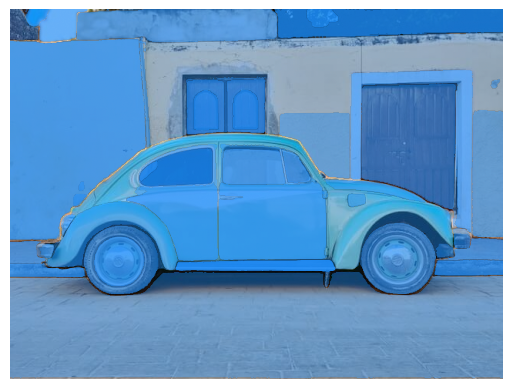

In [29]:
outputs = SAM_gen(raw_image, points_per_batch=64)
masks = outputs["masks"]
show_masks_on_image(raw_image, masks)

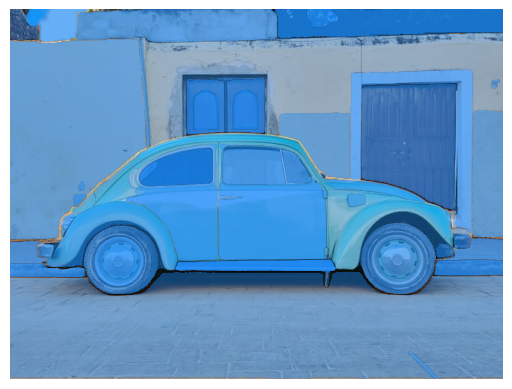

In [31]:
sam_masks = TEST_gen.generate(np.array(raw_image))
sam_masks = [m['segmentation'] for m in sam_masks]
show_masks_on_image(raw_image, sam_masks)

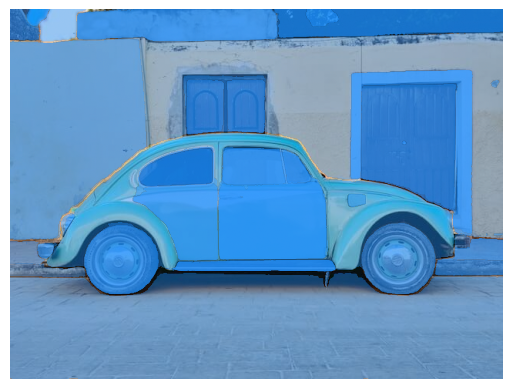

In [45]:
mobilesam_masks = MOBILESAM_gen.generate(np.array(raw_image))
mobilesam_masks = [m['segmentation'] for m in mobilesam_masks]
show_masks_on_image(raw_image, mobilesam_masks)

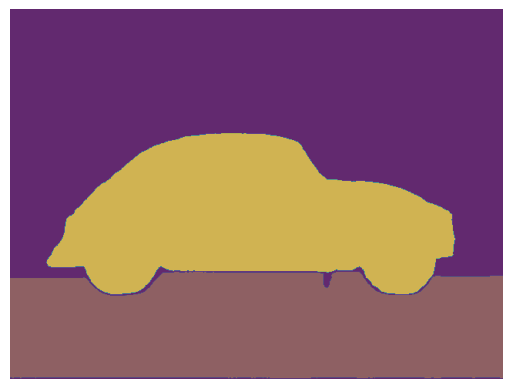

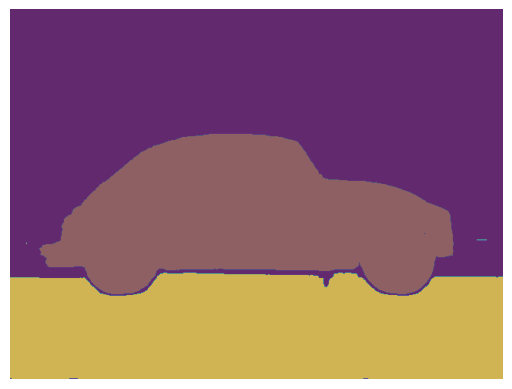

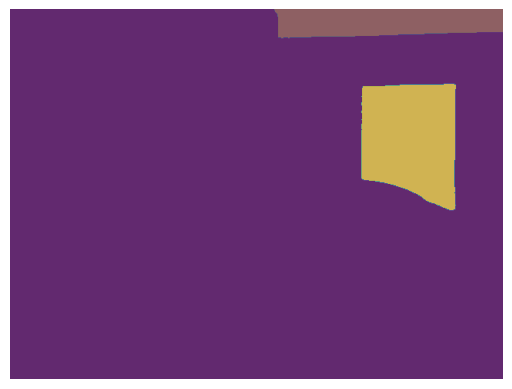

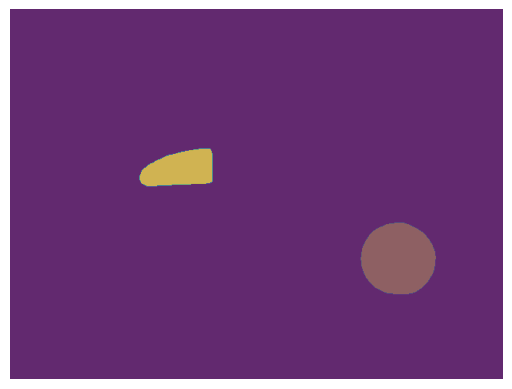

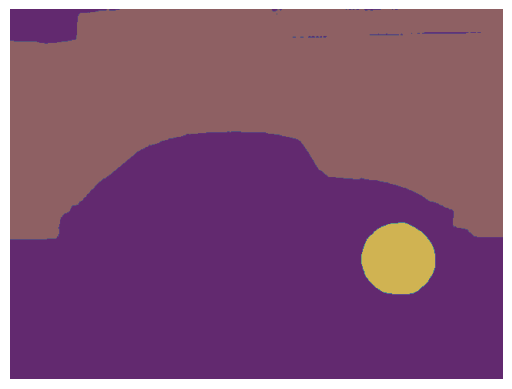

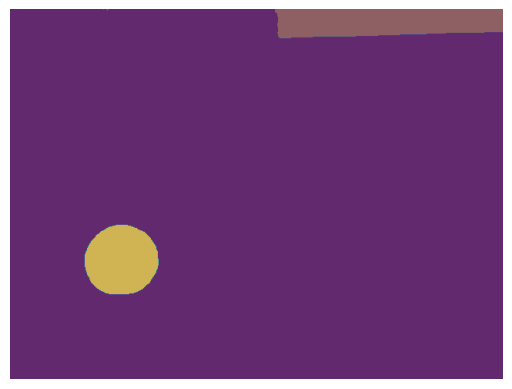

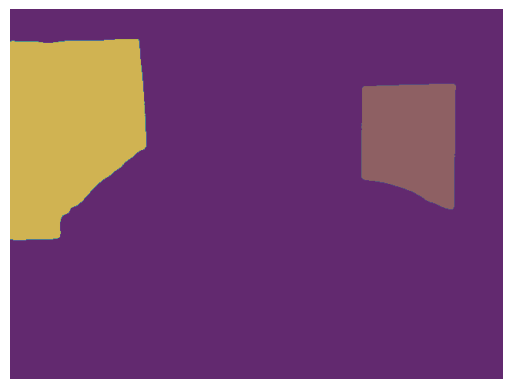

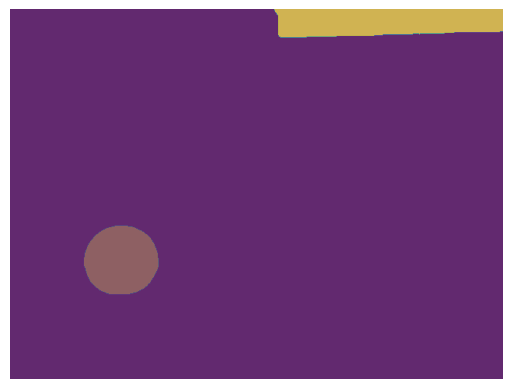

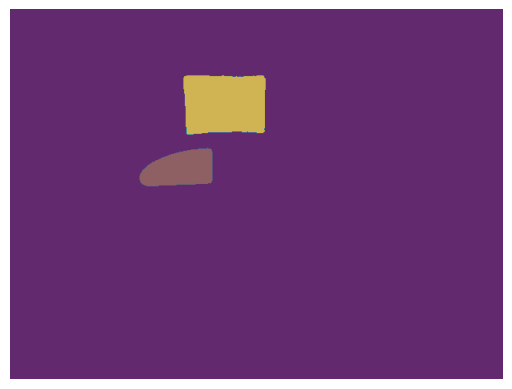

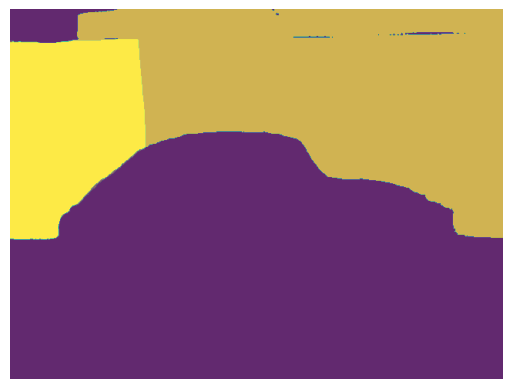

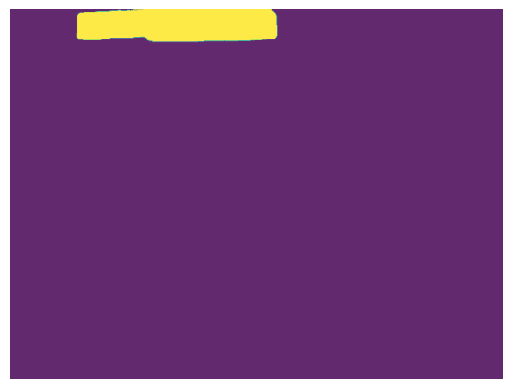

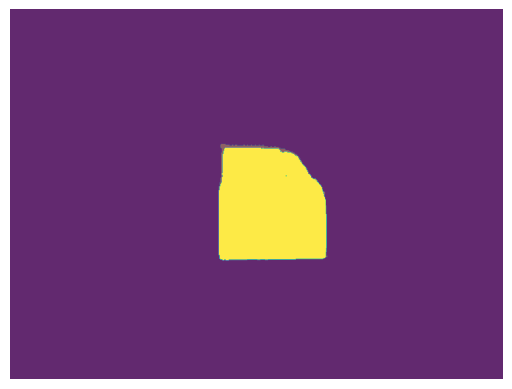

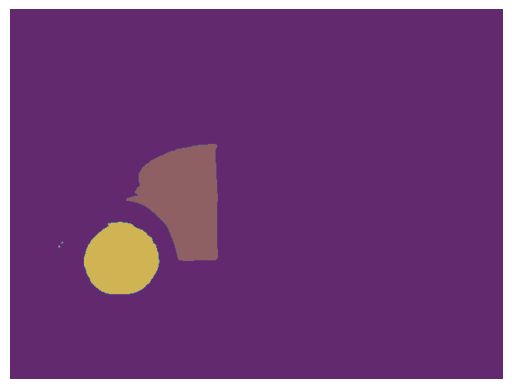

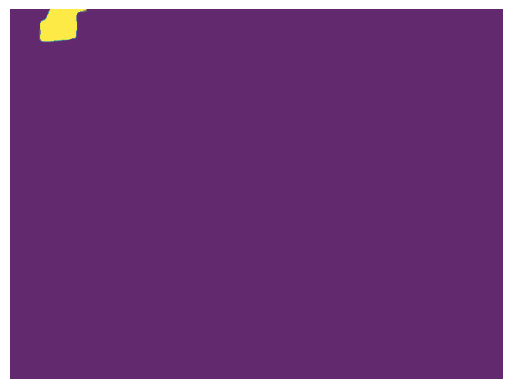

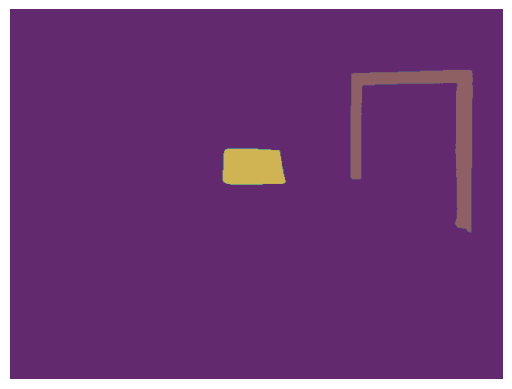

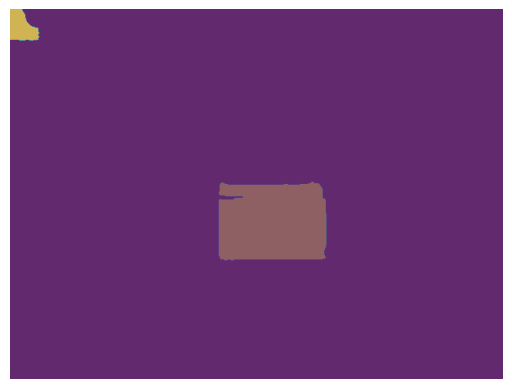

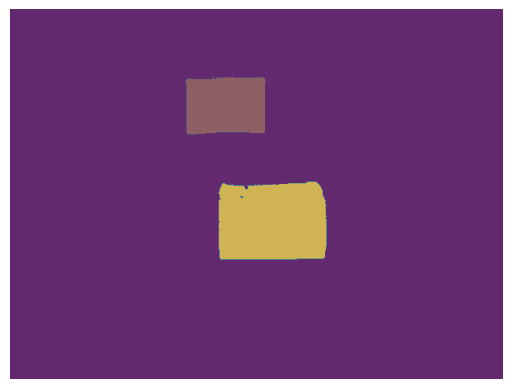

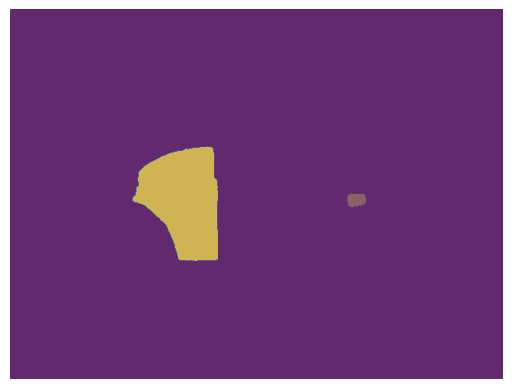

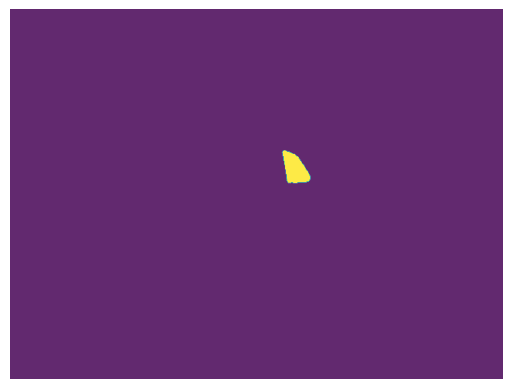

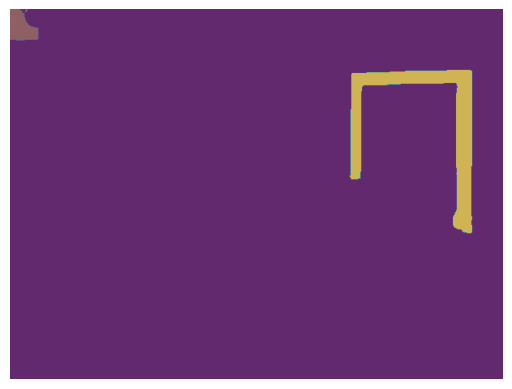

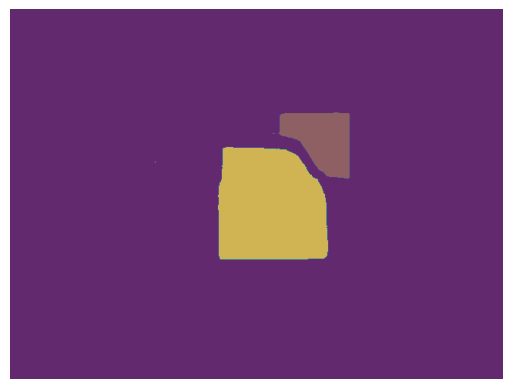

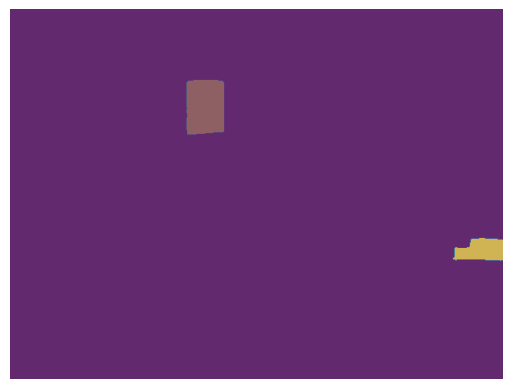

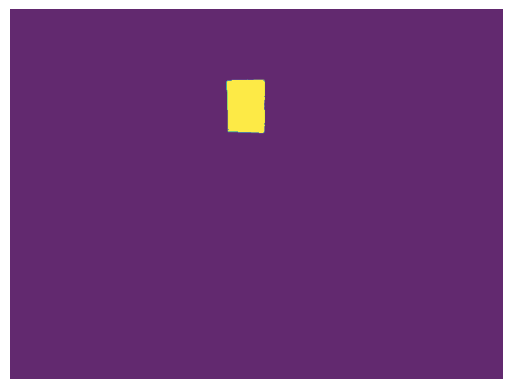

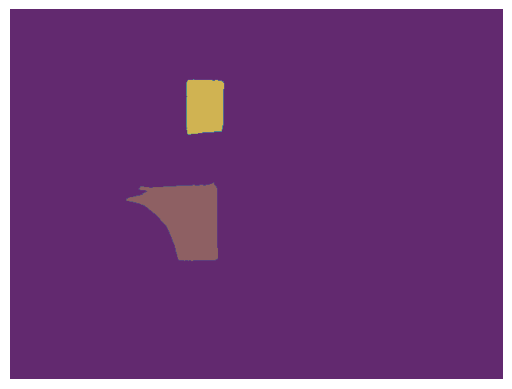

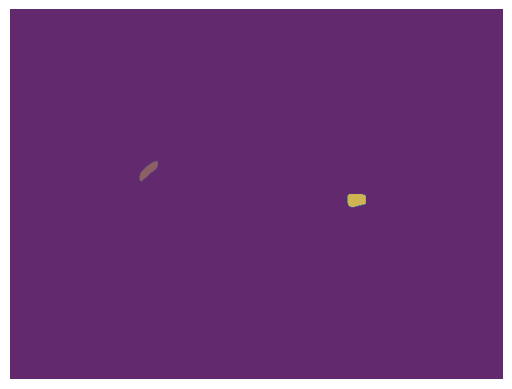

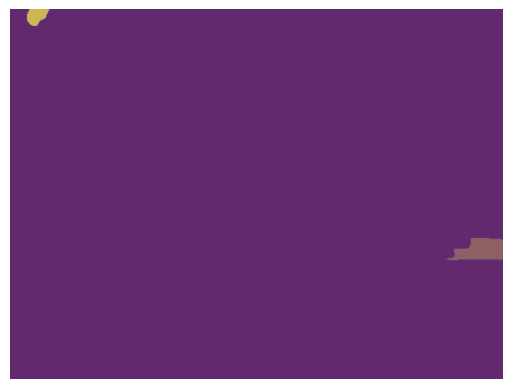

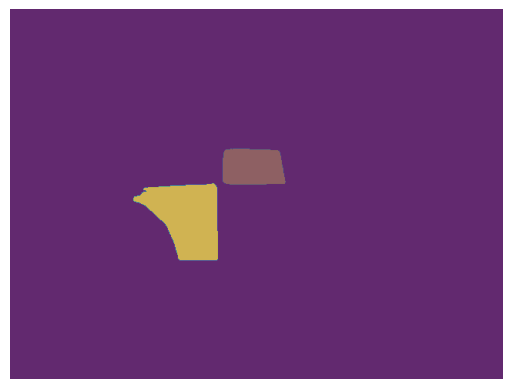

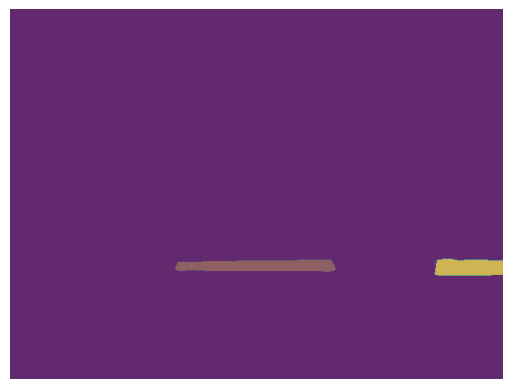

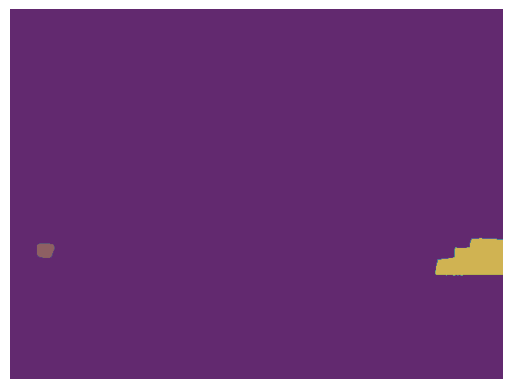

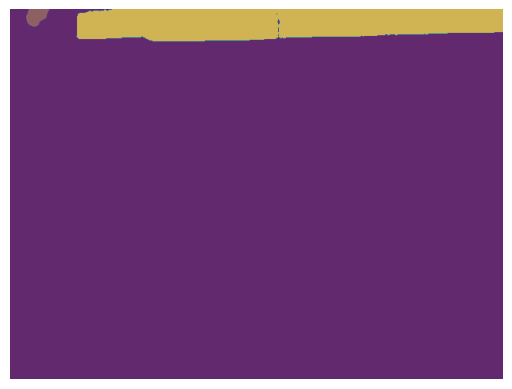

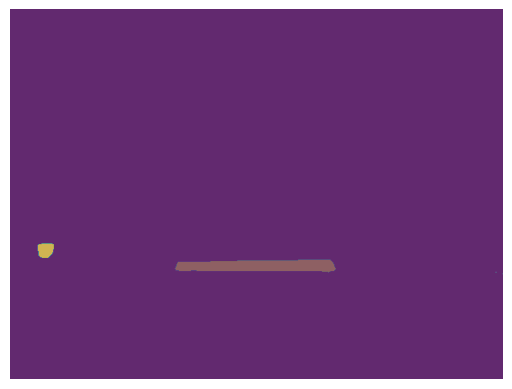

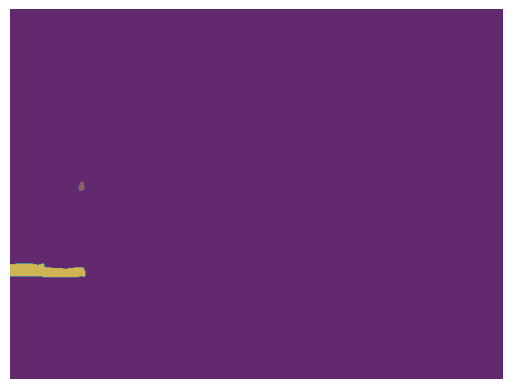

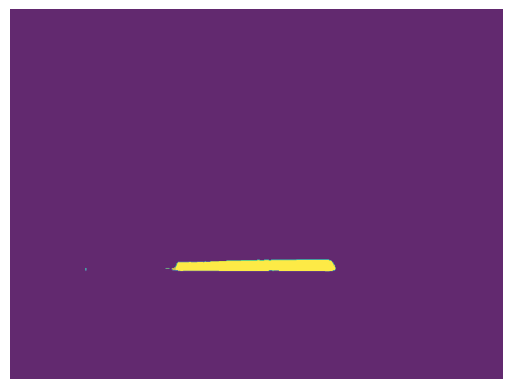

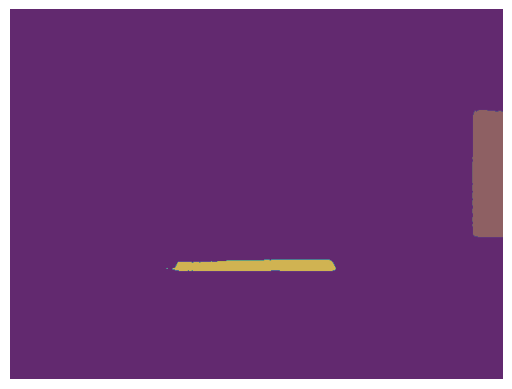

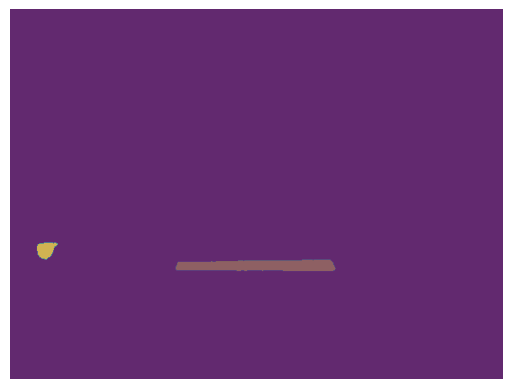

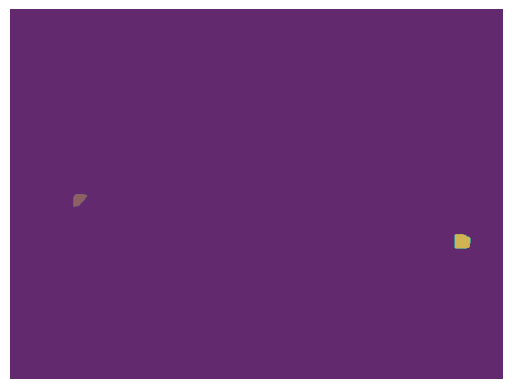

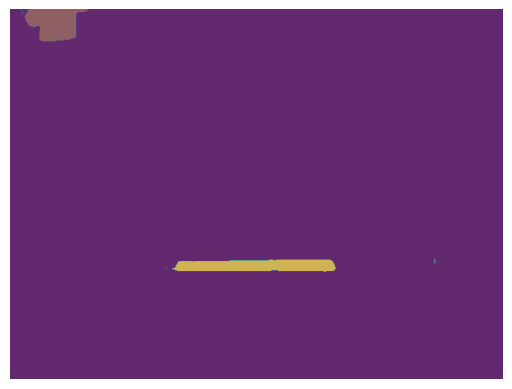

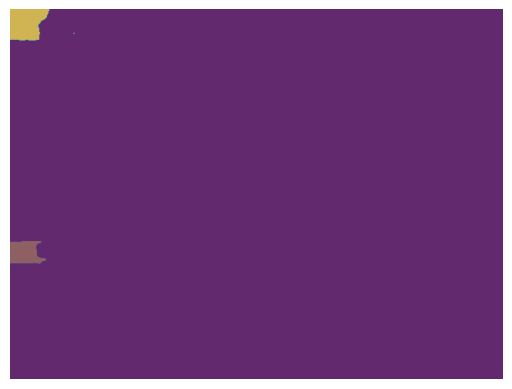

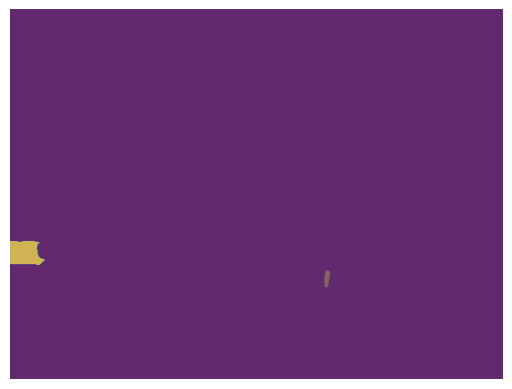

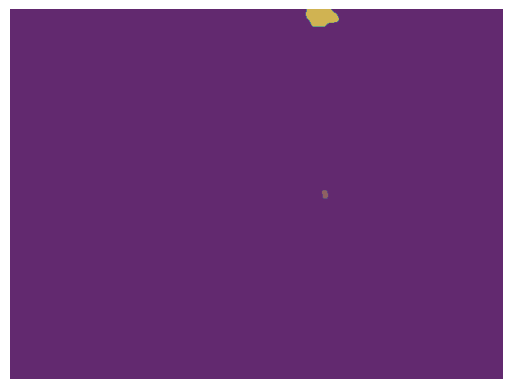

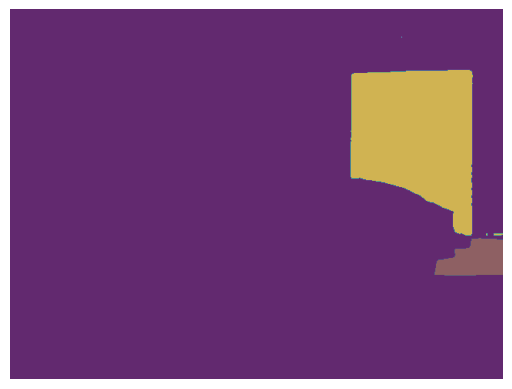

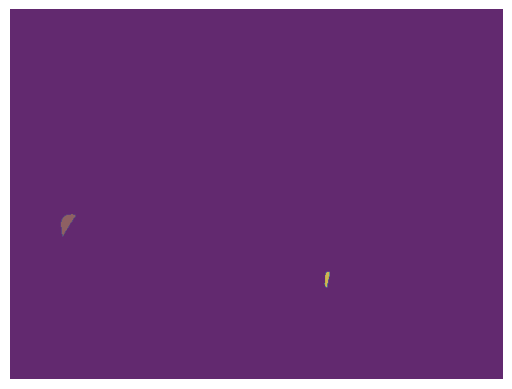

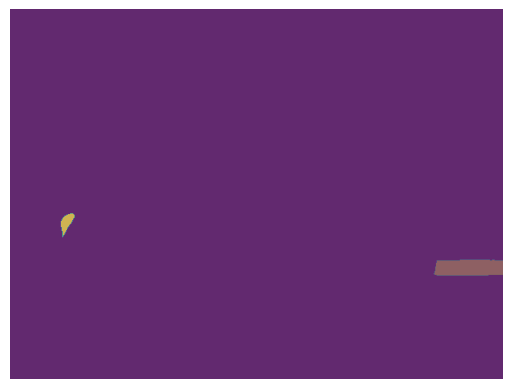

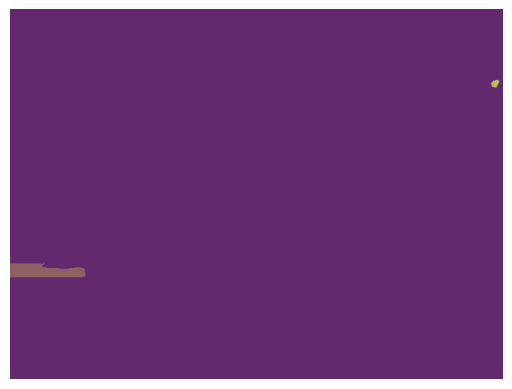

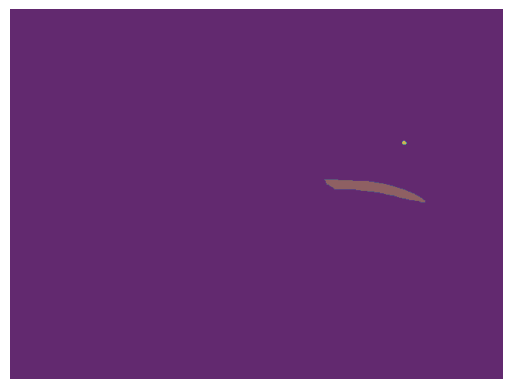

0.06672063078703704

In [46]:
mae = []
for s, m in zip(sam_masks, mobilesam_masks):
    s = s.astype(float)
    m = m.astype(float)
    e = np.mean((s-m)**2)
    mae.append(e)
    if e > 1e-4:
        plt.imshow(s, alpha=0.6)
        plt.imshow(m, alpha=0.6)
        plt.axis('off')
        plt.show()
np.mean(mae)

## Size Prompt Embedding

In [32]:
import torch

EMBED_DIM = 256
CLASSES = 10
DEVICE = 3

In [2]:
delimiters = [5e-4, 8e-4, 1e-3, 2e-3, 3e-3, 5e-3, 9e-3, 2e-2, 9e-2]
size_label = list(range(CLASSES))

In [12]:
def size_to_label(size):
    # return the label of the size based on the delimiters
    for l, d in zip(CLASSES, delimiters):
        if size < d:
            return l
    return size_label[-1]

In [33]:
size_embedding = torch.nn.Embedding(len(size_label), EMBED_DIM).to(DEVICE)

In [34]:
size = 3e-3
size_class = torch.tensor(size_to_label(size)).to(DEVICE)
emb = size_embedding(size_class)

In [35]:
emb.shape

torch.Size([256])

In [43]:
size_embedding.weight.grad_fn